In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense, Activation
from keras.callbacks import TensorBoard, ModelCheckpoint, ReduceLROnPlateau
from keras.models import load_model

import datetime
import os

Using TensorFlow backend.


In [2]:
### 데이터 로드
data = pd.read_csv('dataset/ethereum_dataset.csv', index_col=0)
data.head()

,Open*,High,Low,Close**,Volume,Market Cap
Date,,,,,,
2019-08-13,211.34,211.38,205.42,208.71,5946313205,2.239653e+10
2019-08-12,216.06,216.14,210.95,211.29,5674315559,2.267042e+10
2019-08-11,206.73,216.60,206.51,216.09,6440605605,2.318300e+10
2019-08-10,210.53,213.73,203.79,206.73,6584748527,2.217611e+10
2019-08-09,220.91,221.36,208.25,210.49,6964818795,2.257606e+10


In [3]:
## 정규화 함수
def normalize_windows(data):
    normalized_data = []

    for window in data:
        normalized_window = [((float(p) / float(window[0])) - 1) for p in window]
        normalized_data.append(normalized_window)
        
    return np.array(normalized_data)

In [4]:
### 데이터 전처리
## price data
high_prices = data['High'].values
low_prices = data['Low'].values

mid_prices = (high_prices + low_prices) / 2

seq_len = 30
sequence_length = seq_len + 1

price = []
for index in range(len(mid_prices) - sequence_length):
    price.append(mid_prices[index: index + sequence_length])
    
norm_price = normalize_windows(price)

In [5]:
## volume data
volume_data = data['Volume'].values

volume = []
for index in range(len(volume_data) - sequence_length):
    volume.append(volume_data[index: index + sequence_length])
    
norm_volume = normalize_windows(volume)

In [6]:
def marge_data(price, volume):
    marged_data = []
    marge = []
    
    for p_index, v_index in zip(price, volume):
        for i in range(len(p_index)):
            marge.append(p_index[i])
            marge.append(v_index[i])
        
        marge.pop()
        marged_data.append(marge)
        marge = []
    
    return np.array(marged_data)

norm_result = marge_data(norm_price, norm_volume)

In [7]:
train_cut = -90 # 마지막 3달의 데이터를 test데이터로 한다
        
train = norm_result[:train_cut, :]
np.random.shuffle(train)

x_train = train[:, :-1]
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
y_train = train[:, -1]

x_test = norm_result[train_cut:, :-1]
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
y_test = norm_result[train_cut:, -1]

x_train.shape, x_test.shape

((1347, 60, 1), (90, 60, 1))

In [8]:
### 모델 체크포인터 롤백
MODEL_SAVE_FOLBER_PATH = './model/'
if not os.path.exists(MODEL_SAVE_FOLBER_PATH):
    os.mkdir(MODEL_SAVE_FOLBER_PATH)
    
model_path = MODEL_SAVE_FOLBER_PATH + '{epoch:02d}-{val_loss:.4f}.hdf5'

# 체크포인트 생성 코드
cb_checkpoint = ModelCheckpoint(filepath=model_path, monitor='val_loss',verbose=1, save_best_only=True, mode='auto')

In [9]:
### 모델 설계
model = Sequential()

for i in range (4):
    model.add(LSTM(60, return_sequences=True, input_shape=(60, 1)))   

model.add(LSTM(60, return_sequences=False))

model.add(Dense(1, activation='linear'))

model.compile(loss='mse', optimizer='rmsprop')

model.summary()

W0826 14:45:57.379871 23720 deprecation_wrapper.py:119] From D:\_setup\anaconda3\envs\py3.7\lib\site-packages\keras\backend\tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0826 14:45:57.398342 23720 deprecation_wrapper.py:119] From D:\_setup\anaconda3\envs\py3.7\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0826 14:45:57.400846 23720 deprecation_wrapper.py:119] From D:\_setup\anaconda3\envs\py3.7\lib\site-packages\keras\backend\tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0826 14:45:58.189680 23720 deprecation_wrapper.py:119] From D:\_setup\anaconda3\envs\py3.7\lib\site-packages\keras\optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 60, 60)            14880     
_________________________________________________________________
lstm_2 (LSTM)                (None, 60, 60)            29040     
_________________________________________________________________
lstm_3 (LSTM)                (None, 60, 60)            29040     
_________________________________________________________________
lstm_4 (LSTM)                (None, 60, 60)            29040     
_________________________________________________________________
lstm_5 (LSTM)                (None, 60)                29040     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 61        
Total params: 131,101
Trainable params: 131,101
Non-trainable params: 0
_________________________________________________________________


In [10]:
### 모델 학습
start_time = datetime.datetime.now().strftime('%Y_%m_%d_%H_%M_%S')

model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=30, batch_size=30, callbacks=[cb_checkpoint])

W0826 14:46:05.844889 23720 deprecation.py:323] From D:\_setup\anaconda3\envs\py3.7\lib\site-packages\tensorflow\python\ops\math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
W0826 14:46:07.979967 23720 deprecation_wrapper.py:119] From D:\_setup\anaconda3\envs\py3.7\lib\site-packages\keras\backend\tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.

W0826 14:46:07.985449 23720 deprecation_wrapper.py:119] From D:\_setup\anaconda3\envs\py3.7\lib\site-packages\keras\backend\tensorflow_backend.py:973: The name tf.assign is deprecated. Please use tf.compat.v1.assign instead.



Train on 1347 samples, validate on 90 samples
Epoch 1/30
1347/1347 [==============================] - 26s 19ms/step - loss: 0.0921 - val_loss: 0.1873

Epoch 00001: val_loss improved from inf to 0.18732, saving model to ./model/01-0.1873.hdf5
Epoch 2/30
1347/1347 [==============================] - 21s 16ms/step - loss: 0.0756 - val_loss: 0.1991

Epoch 00002: val_loss did not improve from 0.18732
Epoch 3/30
1347/1347 [==============================] - 22s 17ms/step - loss: 0.0711 - val_loss: 0.1903

Epoch 00003: val_loss did not improve from 0.18732
Epoch 4/30
1347/1347 [==============================] - 21s 16ms/step - loss: 0.0687 - val_loss: 0.1906

Epoch 00004: val_loss did not improve from 0.18732
Epoch 5/30
1347/1347 [==============================] - 21s 16ms/step - loss: 0.0641 - val_loss: 0.1832

Epoch 00005: val_loss improved from 0.18732 to 0.18323, saving model to ./model/05-0.1832.hdf5
Epoch 6/30
1347/1347 [==============================] - 22s 16ms/step - loss: 0.0603 - val

In [ ]:
### 학습 모델 로드
# model = load_model('ether_prediction_model_achi_1.h5')
model = load_model('ether_prediction_model_achi_2.h5')
# model = load_model('ether_prediction_model_achi_3.h5')

In [11]:
## 모델 저장
model. save('ether_prediction_model_achi_2.h5')

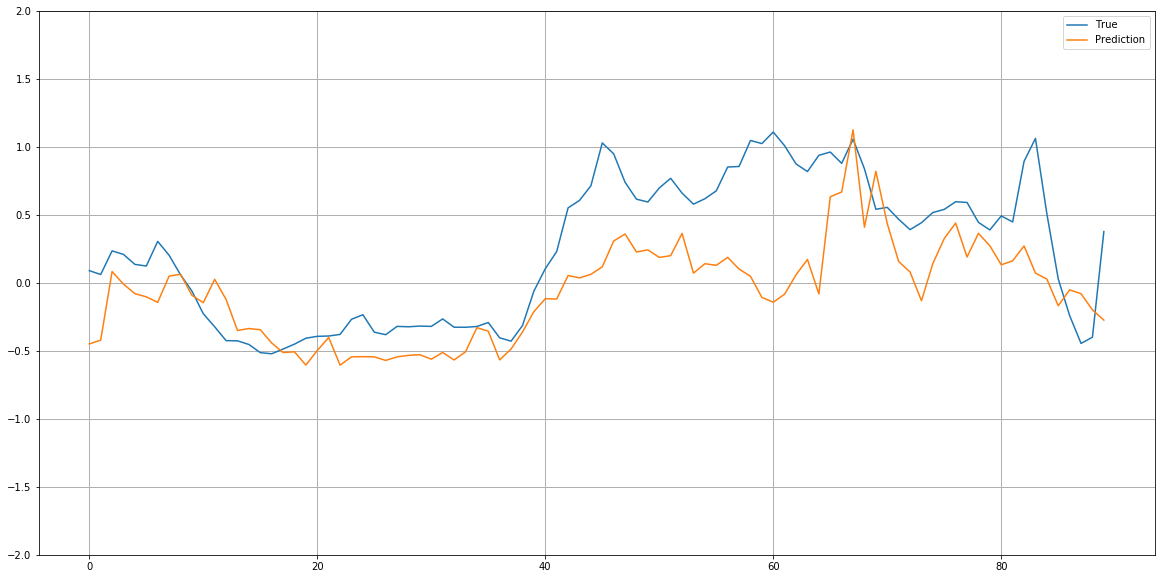

In [12]:
pred = model.predict(x_test)

fig = plt.figure(facecolor='white', figsize=(20, 10))
ax = fig.add_subplot(111)
ax.plot(y_test, label='True')
ax.plot(pred, label='Prediction')
ax.legend()
ax.grid(linestyle='-', linewidth=1,)
plt.ylim([-2, 2])
plt.show()